# pm2.5 training notebook

In [1]:
import json
import datetime as dt
import pytz
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection

## Functions that get data from server to us

In [2]:
def get_data_by_pos(pos):
    r = requests.get(f'http://140.116.82.93:6800/campus/display/{ pos }')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

In [3]:
def get_all_data():
    r = requests.get(f'http://140.116.82.93:6800/training')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

## 不區分 Position 的 Linear Regression

未完成...

### Load data


In [4]:
data = get_all_data()

In [5]:
df = pd.DataFrame(data)

### Data preprocessing

In [6]:
# rename the names of columns
df = df.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})

In [7]:
df.head()

,_cls,date,humidity,pm1.0,pm10.0,pm2.5,position,temp
0,models.data_model.PMData,2019-05-11 09:28:17+08:00,62,50,94,78,3,28
1,models.data_model.PMData,2019-05-11 09:29:44+08:00,67,42,81,72,5,27
2,models.data_model.PMData,2019-05-11 09:43:14+08:00,61,36,71,60,3,29
3,models.data_model.PMData,2019-05-11 09:44:42+08:00,67,41,82,70,5,27
4,models.data_model.PMData,2019-05-11 09:58:13+08:00,59,39,75,63,3,29


In [8]:
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['weekday'] = df['date'].apply(lambda x: x.weekday)
df['hour'] = df['date'].apply(lambda x: x.hour)
df['hour_minute'] = df['date'].apply(lambda x: x.hour+x.minute/60)

In [9]:
df.head()

,_cls,date,humidity,pm1.0,pm10.0,pm2.5,position,temp,month,day,weekday,hour,hour_minute
0,models.data_model.PMData,2019-05-11 09:28:17+08:00,62,50,94,78,3,28,5,11,5,9,9.466667
1,models.data_model.PMData,2019-05-11 09:29:44+08:00,67,42,81,72,5,27,5,11,5,9,9.483333
2,models.data_model.PMData,2019-05-11 09:43:14+08:00,61,36,71,60,3,29,5,11,5,9,9.716667
3,models.data_model.PMData,2019-05-11 09:44:42+08:00,67,41,82,70,5,27,5,11,5,9,9.733333
4,models.data_model.PMData,2019-05-11 09:58:13+08:00,59,39,75,63,3,29,5,11,5,9,9.966667


In [10]:
df.drop(columns=['_cls', 'date'], inplace=True)
df.head()

,humidity,pm1.0,pm10.0,pm2.5,position,temp,month,day,weekday,hour,hour_minute
0,62,50,94,78,3,28,5,11,5,9,9.466667
1,67,42,81,72,5,27,5,11,5,9,9.483333
2,61,36,71,60,3,29,5,11,5,9,9.716667
3,67,41,82,70,5,27,5,11,5,9,9.733333
4,59,39,75,63,3,29,5,11,5,9,9.966667


In [11]:
df[['pm2.5_next']] = df[['pm2.5']].shift(-1)

In [12]:
df.dropna(inplace=True)
df.tail()

,humidity,pm1.0,pm10.0,pm2.5,position,temp,month,day,weekday,hour,hour_minute,pm2.5_next
32301,81,3,4,4,5,25,7,11,3,1,1.066667,2.0
32302,78,1,2,2,7,25,7,11,3,1,1.100000,4.0
32303,92,3,4,4,0,22,7,11,3,1,1.116667,4.0
32304,84,3,4,4,3,24,7,11,3,1,1.150000,3.0
32305,75,2,3,3,2,25,7,11,3,1,1.166667,5.0


In [13]:
four_fifth_len = len(df)*0.8
four_fifth_len = int(four_fifth_len)

In [14]:
train_df = df[:four_fifth_len]
test_df = df[four_fifth_len:]

In [15]:
X = train_df[['month', 'day', 'hour', 'pm1.0', 'pm10.0', 'pm2.5', 'temp', 'humidity', 'position']]
y = train_df[['pm2.5_next']]

In [16]:
test_X = test_df[['month', 'day', 'hour', 'pm1.0', 'pm10.0', 'pm2.5', 'temp', 'humidity', 'position']]
test_y = test_df[['pm2.5_next']]

## 特定一個 position 的 Linear Regression

暫定的做法是：將每一小時的資料做平均，然後將下一小時的 pm2.5 平均當作想要預測的 y。如果下一小時的 pm2.5 平均無法取得(資料缺失)，則將該 row 捨棄。拿來訓練的 columns 目前有 'month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity'。

### Load data


In [17]:
data3 = get_data_by_pos(3)

In [18]:
df3 = pd.DataFrame(data3)

In [19]:
df3

,date,humidity,pm10,pm100,pm25,temp
0,2019-05-11 09:28:17+08:00,62,50,94,78,28
1,2019-05-11 09:43:14+08:00,61,36,71,60,29
2,2019-05-11 09:58:13+08:00,59,39,75,63,29
3,2019-05-11 10:13:10+08:00,59,41,78,66,29
4,2019-05-11 10:28:07+08:00,59,33,67,52,30
5,2019-05-11 10:43:04+08:00,58,39,78,64,30
6,2019-05-11 10:58:01+08:00,56,36,68,57,30
7,2019-05-11 11:12:58+08:00,55,33,66,52,31
8,2019-05-11 11:27:56+08:00,51,27,55,43,32
9,2019-05-11 11:42:54+08:00,51,29,58,44,32


### Data preprocessing

In [20]:
# rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})

In [21]:
# split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)

In [22]:
# set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]

In [23]:
df3.head()

,month,day,weekday,hour,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,5,11,5,9,9.466667,50,78,94,28,62
1,5,11,5,9,9.716667,36,60,71,29,61
2,5,11,5,9,9.966667,39,63,75,29,59
3,5,11,5,10,10.216667,41,66,78,29,59
4,5,11,5,10,10.466667,33,52,67,30,59


In [24]:
# evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()

In [25]:
df3mean

weekday  hour_minute      pm1.0  pm2.5  pm10.0       temp  \
month day hour                                                              
5     11  9         5.0     9.716667  41.666667  67.00   80.00  28.666667   
          10        5.0    10.591667  37.250000  59.75   72.75  29.750000   
          11        5.0    11.575000  28.500000  44.25   56.25  31.750000   
          12        5.0    12.575000  21.500000  32.00   37.00  35.000000   
          13        5.0    13.575000  18.500000  23.75   24.75  37.250000   
          14        5.0    14.575000  17.000000  22.50   23.50  37.750000   
          15        5.0    15.575000  19.000000  25.25   26.25  36.000000   
          16        5.0    16.575000  19.750000  26.50   29.00  32.500000   
          17        5.0    17.575000  14.250000  20.00   20.75  29.000000   
          18        5.0    18.575000  12.250000  17.25   18.75  27.000000   
          19        5.0    19.566667  15.750000  21.50   23.50  26.000000   
          20        5.0    20.558333  16.250000  23.25   26.00  26.000000   
          21        5.0    21.558333  17.000000  27.25   29.50  26.000000   
          22        5.0    22.558333  21.750000  33.25   39.25  26.000000   
          23        5.0    23.558333  24.500000  36.50   45.00  25.250000   
      12  0         6.0     0.558333  28.250000  42.50   54.00  25.000000   
          1         6.0     1.541667  28.750000  44.25   55.00  25.000000   
          2         6.0     2.541667  28.250000  42.75   53.00  24.750000   
          3         6.0     3.541667  28.250000  43.25   56.25  24.000000   
          4         6.0     4.541667  31.000000  49.00   63.00  24.000000   
          5         6.0     5.541667  28.750000  47.50   60.75  24.000000   
          6         6.0     6.541667  29.250000  47.25   60.75  24.500000   
          7         6.0     7.525000  30.000000  46.75   59.75  25.750000   
          8         6.0     8.525000  29.500000  46.75   61.75  27.250000   
          9         6.0     9.525000  27.500000  44.00   55.25  29.000000   
          10        6.0    10.525000  31.000000  48.00   62.00  30.000000   
          11        6.0    11.525000  29.250000  44.00   54.00  31.000000   
          12        6.0    12.525000  24.000000  37.00   43.50  32.500000   
          13        6.0    13.508333  21.500000  32.00   36.50  34.250000   
          14        6.0    14.508333  21.500000  32.75   38.00  35.250000   
...                 ...          ...        ...    ...     ...        ...   
7     9   20        1.0    20.583333   7.250000  11.25   12.00  26.000000   
          21        1.0    21.575000  11.250000  13.75   15.25  26.000000   
          22        1.0    22.575000  11.500000  16.00   17.50  26.000000   
          23        1.0    23.575000  12.250000  17.00   20.25  26.000000   
      10  0         2.0     0.575000  10.500000  15.25   18.25  26.000000   
          1         2.0     1.570833   9.500000  14.00   16.25  26.000000   
          2         2.0     2.558333  13.250000  17.50   20.25  26.000000   
          3         2.0     3.558333  11.750000  17.00   19.50  26.000000   
          4         2.0     4.558333  11.000000  16.75   20.50  26.000000   
          5         2.0     5.558333   9.250000  12.75   16.00  26.000000   
          6         2.0     6.558333  10.250000  14.75   17.75  26.000000   
          7         2.0     7.541667  11.750000  16.75   19.00  26.000000   
          8         2.0     8.541667  13.500000  19.50   21.75  26.750000   
          9         2.0     9.541667  12.750000  20.00   23.75  27.750000   
          10        2.0    10.541667  13.250000  19.00   24.00  28.500000   
          11        2.0    11.541667  13.750000  19.50   22.00  27.000000   
          12        2.0    12.541667  12.250000  17.25   19.75  26.500000   
          13        2.0    13.541667  15.250000  23.00   30.00  27.000000   
          14        2.0    14.541667  11.750000  18.75   25.00  28.000000   
          15

In [26]:
df3mean.reset_index(inplace=True)

In [27]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,5,11,9,5.0,9.716667,41.666667,67.00,80.00,28.666667,60.666667
1,5,11,10,5.0,10.591667,37.250000,59.75,72.75,29.750000,58.000000
2,5,11,11,5.0,11.575000,28.500000,44.25,56.25,31.750000,51.500000
3,5,11,12,5.0,12.575000,21.500000,32.00,37.00,35.000000,43.500000
4,5,11,13,5.0,13.575000,18.500000,23.75,24.75,37.250000,37.750000


In [28]:
# reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)

In [29]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,time
0,5,11,9,5.0,9.716667,41.666667,67.00,80.00,28.666667,60.666667,2019-05-11 08:54:00+08:00
1,5,11,10,5.0,10.591667,37.250000,59.75,72.75,29.750000,58.000000,2019-05-11 09:54:00+08:00
2,5,11,11,5.0,11.575000,28.500000,44.25,56.25,31.750000,51.500000,2019-05-11 10:54:00+08:00
3,5,11,12,5.0,12.575000,21.500000,32.00,37.00,35.000000,43.500000,2019-05-11 11:54:00+08:00
4,5,11,13,5.0,13.575000,18.500000,23.75,24.75,37.250000,37.750000,2019-05-11 12:54:00+08:00


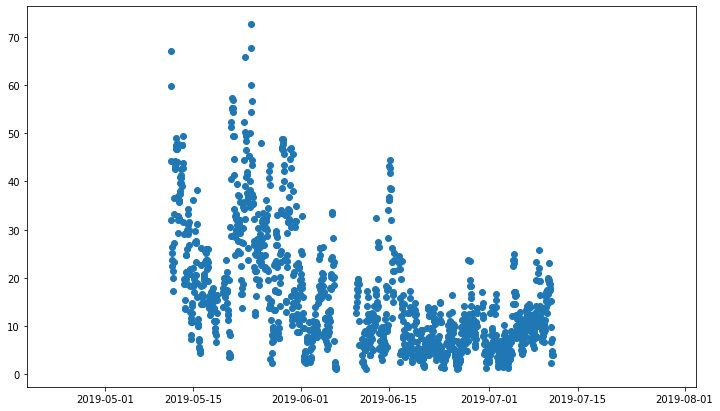

In [30]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()

# plt
plt.figure(figsize=(12, 7))
plt.scatter(df3mean['time'], df3mean['pm2.5'])


In [31]:
df3mean[['pm2.5_shift-1']] = df3mean[['pm2.5']].shift(-1)

In [32]:
df3mean[['time_shift-1']] = df3mean[['time']].shift(-1)

In [33]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,time,pm2.5_shift-1,time_shift-1
0,5,11,9,5.0,9.716667,41.666667,67.00,80.00,28.666667,60.666667,2019-05-11 08:54:00+08:00,59.75,2019-05-11 09:54:00+08:00
1,5,11,10,5.0,10.591667,37.250000,59.75,72.75,29.750000,58.000000,2019-05-11 09:54:00+08:00,44.25,2019-05-11 10:54:00+08:00
2,5,11,11,5.0,11.575000,28.500000,44.25,56.25,31.750000,51.500000,2019-05-11 10:54:00+08:00,32.00,2019-05-11 11:54:00+08:00
3,5,11,12,5.0,12.575000,21.500000,32.00,37.00,35.000000,43.500000,2019-05-11 11:54:00+08:00,23.75,2019-05-11 12:54:00+08:00
4,5,11,13,5.0,13.575000,18.500000,23.75,24.75,37.250000,37.750000,2019-05-11 12:54:00+08:00,22.50,2019-05-11 13:54:00+08:00


In [34]:
# check the next row is the next hour or not. 
# If it is not, the `pm2.5_next_hour` column will be given NaN.

def check_next_hour(x):
    one_hour = dt.timedelta(hours=1)
    if x[2] - x[1] == one_hour:
        return x[0]
    return np.nan

df3mean['pm2.5_next_hour'] = df3mean[['pm2.5_shift-1', 'time', 'time_shift-1']].apply(check_next_hour, axis=1)

In [35]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,time,pm2.5_shift-1,time_shift-1,pm2.5_next_hour
0,5,11,9,5.0,9.716667,41.666667,67.00,80.00,28.666667,60.666667,2019-05-11 08:54:00+08:00,59.75,2019-05-11 09:54:00+08:00,59.75
1,5,11,10,5.0,10.591667,37.250000,59.75,72.75,29.750000,58.000000,2019-05-11 09:54:00+08:00,44.25,2019-05-11 10:54:00+08:00,44.25
2,5,11,11,5.0,11.575000,28.500000,44.25,56.25,31.750000,51.500000,2019-05-11 10:54:00+08:00,32.00,2019-05-11 11:54:00+08:00,32.00
3,5,11,12,5.0,12.575000,21.500000,32.00,37.00,35.000000,43.500000,2019-05-11 11:54:00+08:00,23.75,2019-05-11 12:54:00+08:00,23.75
4,5,11,13,5.0,13.575000,18.500000,23.75,24.75,37.250000,37.750000,2019-05-11 12:54:00+08:00,22.50,2019-05-11 13:54:00+08:00,22.50


In [36]:
df3mean.isna().sum()

month              0
day                0
hour               0
weekday            0
hour_minute        0
pm1.0              0
pm2.5              0
pm10.0             0
temp               0
humidity           0
time               0
pm2.5_shift-1      1
time_shift-1       1
pm2.5_next_hour    9
dtype: int64

In [37]:
# discard rows that contain NaN value
df3mean.dropna(inplace=True)

In [38]:
df3mean.isna().sum()

month              0
day                0
hour               0
weekday            0
hour_minute        0
pm1.0              0
pm2.5              0
pm10.0             0
temp               0
humidity           0
time               0
pm2.5_shift-1      0
time_shift-1       0
pm2.5_next_hour    0
dtype: int64

### Normalization

$z = \frac{x- μ}{σ}$


In [39]:
df3mean_time = df3mean['time_shift-1']
df3mean.drop(columns=['time', 'time_shift-1'], axis=0, inplace=True)

df3mean = (df3mean - df3mean.mean()) / df3mean.std()

### Divid training set and test set

In [40]:
four_fifth_len = len(df3mean)*0.8
four_fifth_len = int(four_fifth_len)

In [41]:
train_df = df3mean[:four_fifth_len]
test_df = df3mean[four_fifth_len:]

test_df_time = df3mean_time[four_fifth_len:]

In [42]:
X = train_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
y = train_df[['pm2.5_next_hour']]

In [43]:
test_X = test_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
test_y = test_df[['pm2.5_next_hour']]

### Fit the model

using `sklearn.linear_model.LinearRegression`

In [44]:
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [45]:
predict_y = model.predict(test_X)
predict_y

array([[-0.61293633],
       [-0.63668798],
       [-0.75995125],
       [-0.89197987],
       [-0.72770771],
       [-0.83721394],
       [-0.67720433],
       [-0.78304921],
       [-1.04970276],
       [-1.12121098],
       [-1.02049972],
       [-0.92602868],
       [-0.95546602],
       [-0.89106297],
       [-0.86283259],
       [-0.88762658],
       [-0.8536734 ],
       [-0.82335756],
       [-0.77183728],
       [-0.96694651],
       [-1.12422642],
       [-1.03954144],
       [-1.02846994],
       [-0.93919082],
       [-0.49966057],
       [-0.88994688],
       [-0.96973434],
       [-1.00587429],
       [-0.81920882],
       [-0.78197671],
       [-0.78779399],
       [-0.48433745],
       [-0.53569694],
       [-0.58986   ],
       [-1.00717516],
       [-1.06609936],
       [-1.01679465],
       [-0.9700522 ],
       [-0.90926227],
       [-0.78667914],
       [-0.72165175],
       [-0.7287431 ],
       [-0.67387774],
       [-0.4063643 ],
       [-0.26580653],
       [-0

In [46]:
# see the coefficients of our model
a = model.coef_
b = model.intercept_
print(a)
print(b)

[[-0.11273983 -0.02500993  0.01667124  0.01669479  0.06343608  0.44126123
   0.34852414 -0.17654831 -0.13406759]]
[-0.0168016]


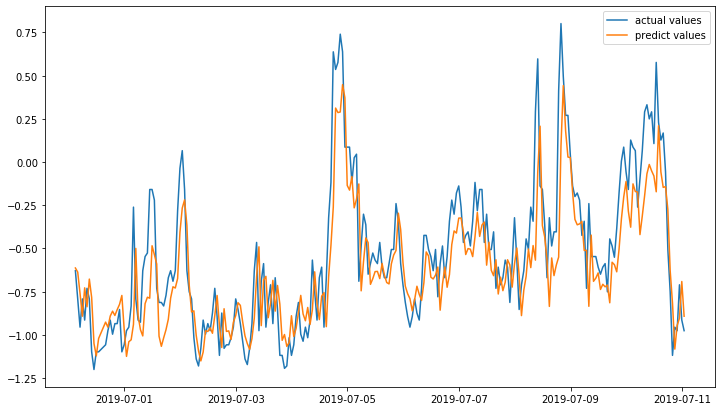

In [47]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()

# plt
plt.figure(figsize=(12, 7))
plt.plot(test_df_time, test_df['pm2.5_next_hour'], label='actual values')
plt.plot(test_df_time, predict_y, label='predict values')
plt.legend()
plt.show()

In [48]:
predict_train_y = model.predict(X)

# mean squared error for training set
mse_train = metrics.mean_squared_error(y, predict_train_y)
np.sqrt(mse_train)

0.35971028005210787

In [49]:
# mean squared error for test test
mse_test = metrics.mean_squared_error(test_y, predict_y)
np.sqrt(mse_test)

0.23980771477239227

### Feature Selection

Our test error is worse than our training error. Therefore, our next job is to improve this.
